# Lecture 2: k-Nearest Neighbors and the Bias-Variance Tradeoff

In this example, we'll use we'll use k-nearest neighbors for regression (predicting a quantitative response) and explore the bias-variance tradeoff.

# scikit-learn
scikit-learn is the most popular set of data science tools for python.  It contains modules for classification, regression, clustering, dimensionality reduction, model selection, and preprocessing.  It also has a few sample data sets.

scikit-learn is extensively docmented online: http://scikit-learn.org/stable/index.html

# Loading Modules
The k-NN regressor is part of scikit-learn: 

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

In [1]:
%matplotlib inline 

In [2]:
import matplotlib.pyplot as plt # Import basic plotting functionality
import seaborn as sns # Import seaborn, which makes plots prettier
from sklearn import neighbors # Import the neighbors module, which includes k-nearest neighbors 
import numpy as np # Import numpy

#  Specifying the True Model
For the purposes of this example, we are going to assume that $Y = f\left(X\right)+\epsilon$ where $X$ is a single quantitative predictor, $Y$ is a quantitative response, $\epsilon$ is a noise term with mean 0, and $f$ has the following form:
$$ f(X) = \frac{10}{1+600\cdot e^{-X}}.$$
*Reminder*: We don't get to do this in real life -normally we're trying to estimate $f$. We're specifying $f$here for the purpose of studying the bias-variance tradeoff.

We can visualize the systematic component $f$ by creating a set of points at which to evaluate $f$ and plotting the results:

In [3]:
# Here we define a function called 'true_fun' that takes in a numpy array,
# and returns the value of the function 'f' defined above at all values in the input array.
# For all functions in python, the code that defines the function is indented and
# the function ends with a 'return' statement that defines the output of the function.
def true_fun(X):
    return (10)/(1+600*np.exp(-X))

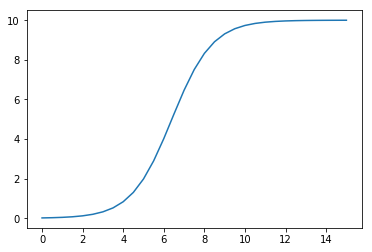

In [4]:
# Next, we generate a range of points at which to evaluate this function, and
# plot the result
sample_points = np.linspace(0,15,31) # Grid of 30 evenly spaced points from 0 to 15, along with 0
y = true_fun(sample_points)
plt.plot(sample_points,y)

We see that the true function $f$ has an s-curve shape (this is in fact  a scaled version of the 'logistic' function).

# Generating Sample Data
Next, we create a function that generates training samples by randomly selecting some specificied number of values of $X$ between 0 and 15, evaluates the true function $f$ at those points, and adds in a noise term to get the response $Y$ at all sampled points.

In [6]:
# The input n_samples must be a positive integer (1,2,3, etc.), and it determines the 
# size of the sample we'll get back.
# We generate the sample X values by asking python for 'n_samples' uniform random numbers,
# and scaling them all by 15 (since we want to sample over the range 0 to 15]).
# We generate the noise terms by asking python for 'n_samples' random numbers sampled from
# a mean 0 normal distribution with standard deviation of 3.
def get_sample(n_samples):
    sample_x = np.sort(np.random.rand(n_samples))*15
    noise_term = np.random.randn(n_samples)
    sample_y = true_fun(sample_x) + noise_term*3
    return (sample_x,sample_y)

Let's test the function by creating one sample with 50 observations.

In [7]:
train_sample = get_sample(50)

In [8]:
train_sample[0] # The sample X values

array([  0.24886623,   0.44228264,   0.76378458,   0.83670995,
         0.88694331,   1.51774611,   1.72317188,   2.01346878,
         2.57727545,   3.01735667,   3.42900052,   3.48616056,
         3.49756876,   3.57019045,   3.62318866,   3.71654494,
         4.19987744,   5.1580111 ,   5.22972075,   5.24618376,
         5.35732186,   5.65250075,   5.68002678,   5.90020874,
         6.0359299 ,   6.11376614,   6.66755491,   6.76417155,
         6.98916418,   7.29511425,   8.01235895,   8.01450708,
         8.06514386,   8.14280992,   8.71369998,   8.75733676,
         8.89599117,   9.07456769,   9.19825694,   9.71198382,
        10.16622195,  10.18925979,  10.41366274,  11.46228532,
        12.40984989,  13.33759235,  13.87681541,  14.46917816,
        14.83712052,  14.85279389])

In [9]:
train_sample[1] # The sample Y values

array([  4.18495325,   0.23494153,   8.66663629,  -1.112067  ,
         1.18795239,   2.94959009,   2.73285273,  -0.76182733,
        -2.430601  ,   0.93520903,   2.78985801,  -0.57176699,
         2.00671414,   1.12025404,  -1.279134  ,  -2.7850392 ,
         0.31246856,   5.01947918,   0.05056631,   6.3382363 ,
        -0.75918013,  10.59362456,   4.23659881,   6.02959652,
         1.326192  ,   5.98956491,   6.65081063,   8.10937875,
         8.04537794,   4.4980367 ,   5.97499107,   6.08389824,
         7.60891735,   6.84888385,   9.41854527,  11.44051665,
        10.54377329,   8.41868831,  10.79628339,  11.08699236,
         4.74439055,   6.87581334,   8.58857978,  11.25913546,
         9.29532381,   9.57699723,   9.67403302,   5.566192  ,
        13.14468558,   7.47308284])

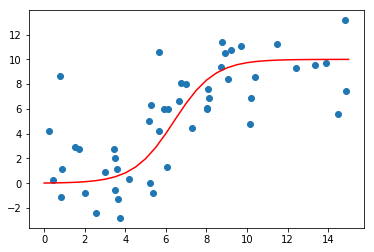

In [10]:
plt.scatter(train_sample[0],train_sample[1]) # Scatter plot for the sample
plt.plot(sample_points,y,color='red') # Line for the true function
plt.show() # Show a single plot with both the sample and true function

# Fitting a K-NN Model Given a Training Set
We will now fit a K-NN model using the training set above, and use it to predict on a test set.

Let's create a set of points at which to test the k-nn model we're about to fit.

In [11]:
test_X = np.linspace(0,15,31)

In [12]:
test_X

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ])

Next, let's fit the k-nn model on our training data, and predict on the test data.

In general, regression models available through scikit-learn all use the same interface.

First, you create an instance of the *class* corresponding to the kind of model you want to use. In this case, we are doing k-nearest neighbors regression and so we want to create an instance of the 'KNeighborsRegressor' class, available through the 'neighbors' module we imported earlier. When creating this instance, we need to specify the number of neighbors we'll be using (other regression techniques may have different inputs).

In [13]:
knn = neighbors.KNeighborsRegressor(n_neighbors=5) # Notice that we haven't passed it any data.

Second, we fit the model to our data using the ```.fit``` function

In [14]:
# We use the training sample created above.
# Note that we don't need to assign this fit to any new python object.
# The fit operation updates the knn object we created, and will be 
# packaged with the knn object from now on (unless we re-train).
knn.fit(train_sample[0],train_sample[1]) 

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found input variables with inconsistent numbers of samples: [1, 50]

This error implies that we need to restructure the input into the knn.fit() call since we're using a single sample.  You will likely get these kinds of errors when first using scikit-learn, but usually the error message will provide guidance on how to fix it.  In this case, we can figure out what's going wrong with a little debugging.

In [15]:
# First, the error is complaining about the shape of train_sample[0], so let's check its shape.
train_sample[0].shape

(50,)

In [16]:
# Ok, seems reasonable.  Now, let's reshape train_sample[0] the way the error is asking us to
# and check the shape of the output.
train_sample[0].reshape(-1,1).shape

(50, 1)

We see that there is a slight difference between train_sample[0] and the reshaped version. Because the shape of train_sample[0] is (50,), the missing value after the comma indicates
that numpy views train_sampe[0] not as a table (or matrix) but as a 1-dimensional object
with 50 elements. However, the shape of train_sample[0].reshape(-1,1) is (50,1), which means that numpy views that object as a 2-dimensional array (or matrix) -one with 50 rows and 1 column.  Based on the error we got when we tried to fit the knn model, it looks like the knn model needs its data to be a 2-dimensional object, not a 1-dimensional object. (For reference, the -1 in the .reshape(-1,1) command tells Python to infer the number of rows in the resulting array by counting the number of elements in the 1-d object being reshaped. In this case, train_sample[0] has 50 elements, and so .reshape(-1,1) creates a 2-d array with 50 rows and 1 column).

Now that we've figured that out, let's go back to fitting the k-nn model.

In [17]:
# After running this, you'll get some detail on how the fit was done.
knn.fit(train_sample[0].reshape(-1,1),train_sample[1])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

Third, we predict on the test set using the ```.predict``` function (reshaping the test values as we did in the ```.fit()``` call, otherwise we get the same error)

In [18]:
test_pred = knn.predict(test_X.reshape(-1,1))
test_pred

array([  2.63248329,   2.63248329,   2.38541066,   0.99930017,
         0.6850447 ,   0.65309829,   0.54588264,   0.81318504,
        -0.12494729,   1.78714223,   4.24854524,   4.09196917,
         5.63511536,   6.02426485,   6.65863379,   6.44224426,
         6.20294544,   9.17212728,  10.12356138,   9.11802558,
         8.41841189,   8.5109823 ,   8.5109823 ,   8.15264859,
         9.11916992,   9.0743363 ,   9.0743363 ,   9.45144633,
         9.08699813,   9.08699813,   9.08699813])

Let's plot the true $f$ against the predictions made by our k-nn regressor (fit using the training data) at each of the test points

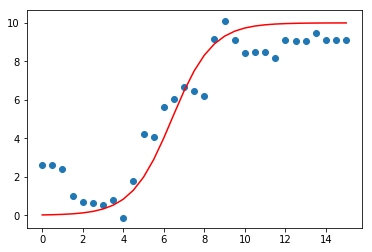

In [19]:
plt.scatter(test_X,test_pred) # Scatter plot for the predictions on the test set
plt.plot(sample_points,y,color='red') # Line for the true function
plt.show() # Show a single plot with both the sample and true function

Not bad!

# Examining the Bias-Variance Tradeoff for Different k-NN Models
Now that we know how to fit a single k-nn model, we're going to generate many training sets and fit severeal k-nn models on each training set.  By looking at the predictions for each of these k-nn models across training sets, we'll be able to visualize the bias variance tradeoff in a different way than in the previous lecture.  We'll also get more experience using lists, dictionaries, and the k-nn regressor from scikit-learn.

First, let's create several k-nn models, each with a different value of $k$.  We'll do this by specifying the values of $k$ we want to use, then iterating over these values to populate a dictionary where the key is $k$ (the number of neighbors) and the value is the k-nn regressor object for the given value of $k$.

In [23]:
# The values of k that we'll be using.  Each one will correspond to a single k-nn regressor.
k_list = (1,5,10,20,30,50)
k_list

(1, 5, 10, 20, 30, 50)

In [24]:
# An empty dictionary that we'll populate with k-nn regressors via iteration.
knn_dict = dict()
knn_dict

{}

In [26]:
# Now let's iterate over our list of values for k to populate the dictionary with k-nn regressors
for k in k_list:
    knn_dict[k] = neighbors.KNeighborsRegressor(n_neighbors=k)
knn_dict

{1: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
 5: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
 10: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform'),
 20: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform'),
 30: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform'),
 50: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weig

In [27]:
knn_dict[5] # Pull an individual k-nn regressor

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [28]:
# Confirm that the value in the knn_dict dictionary for k=5 is in fact a k-nn regressor
type(knn_dict[5]) 

sklearn.neighbors.regression.KNeighborsRegressor

Now, we'll create a loop that creates many different training sets by sampling values of $X$ from the range 0 to 15, trains each of our k-nn models on each sample, and stores the predictions on our ```test_X``` test set above.

In [29]:
num_training_samples = 1000 # Number of training samples

# Initialize a dictionary that will store predicions for each model at each test point
# The dict.fromkeys function takes in a set of key values, and the value
# you want to associate with each key.  Here, the key values are the 
# values of k for our k-nn models, and we initialize the value for each key to be a 
# numpy array of zeros with as many rows as there will be training samples, 
# and one column per test point.
pred_dict = dict()
for k in k_list:
    pred_dict[k] = np.zeros((num_training_samples,len(test_X)))

# Set the seed of our random number generator so we can reproduce results
np.random.seed(8298401)

# Loop over the number of training samples, fit models, and store results
for ix_sample in range(num_training_samples):
    sample = get_sample(50) # Every training set has 50 observations
    for k in k_list:
        knn_model = knn_dict[k]
        knn_model.fit(sample[0].reshape(-1,1),sample[1]) # Fit the knn model using current sample
        preds = knn_model.predict(test_X.reshape(-1,1))
        pred_dict[k][ix_sample] = preds

Finally, we'll generate some plots to explore the results.  For each test point, we'll create a plot with three histograms -one per k-nn model with k =1, 20, and 50- showing the distribution of predictions at the test point for each k-nn model.

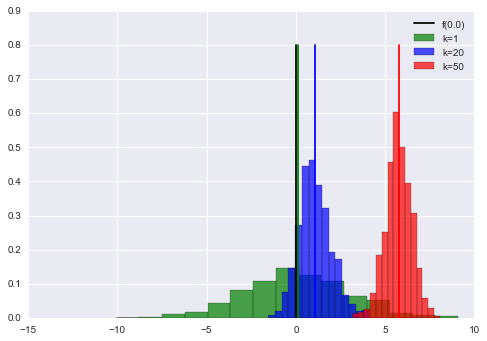

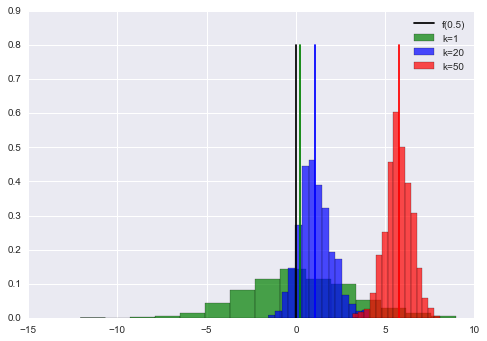

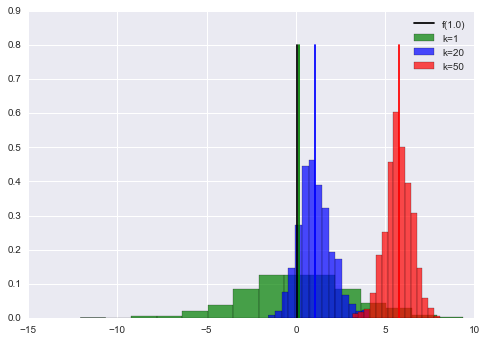

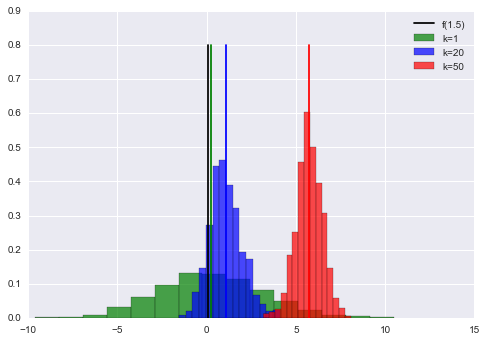

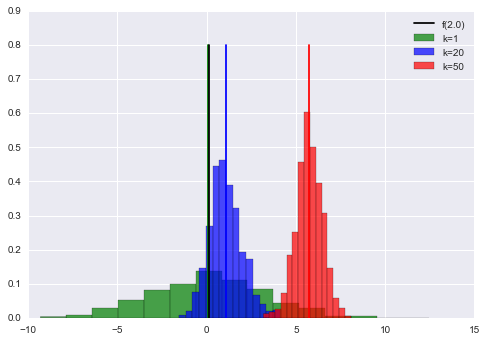

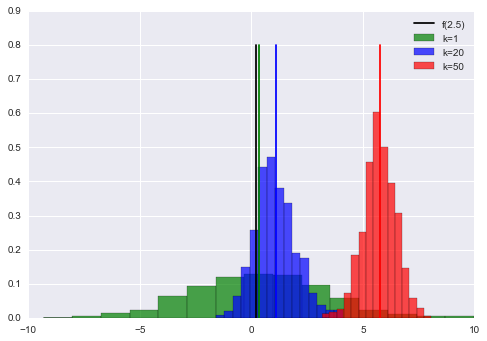

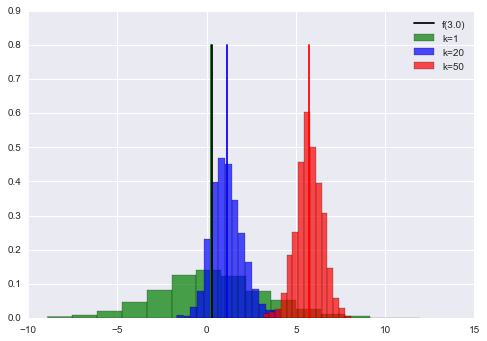

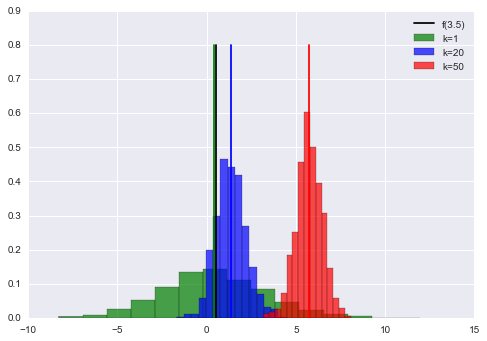

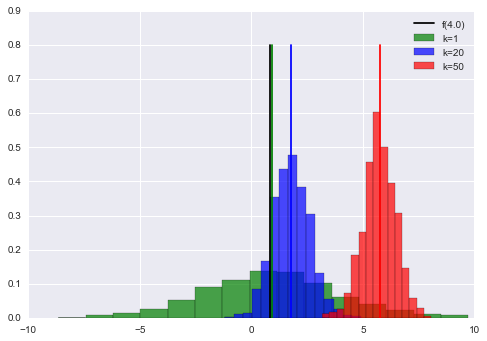

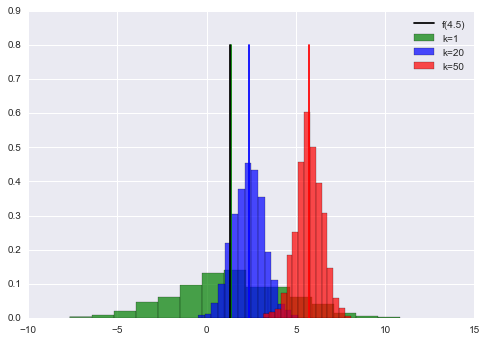

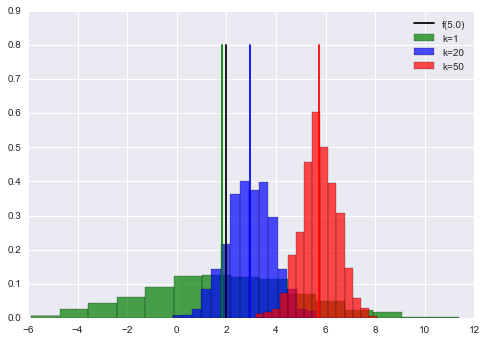

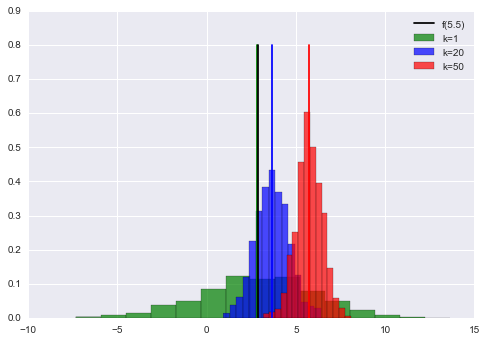

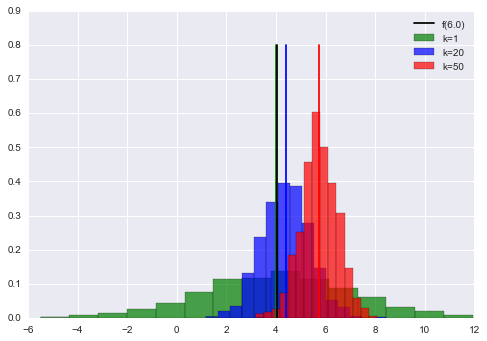

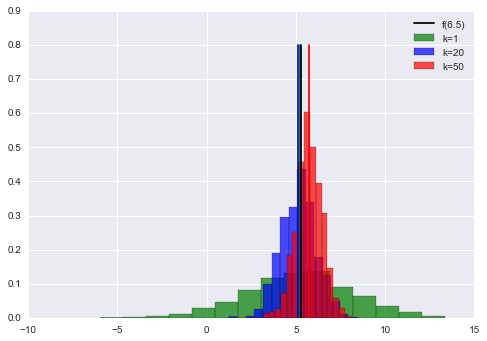

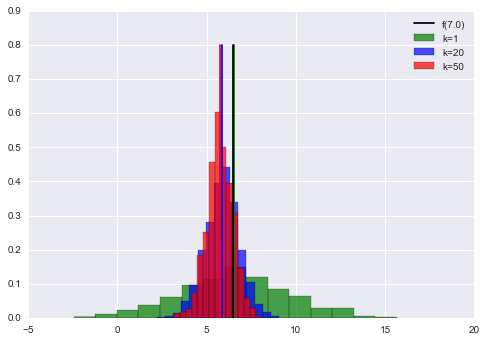

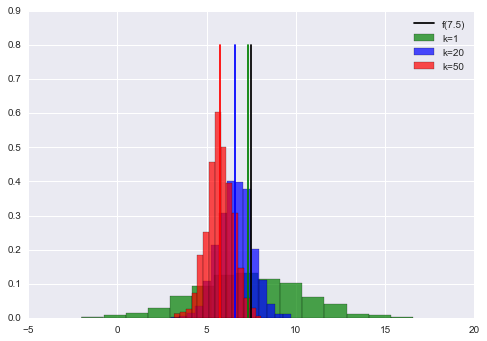

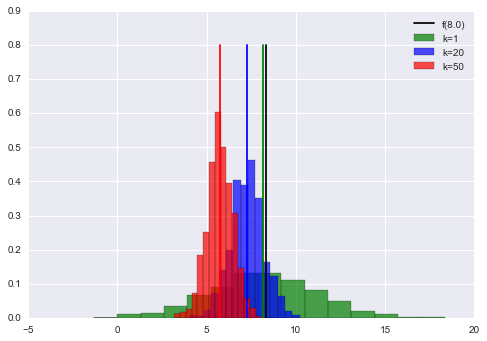

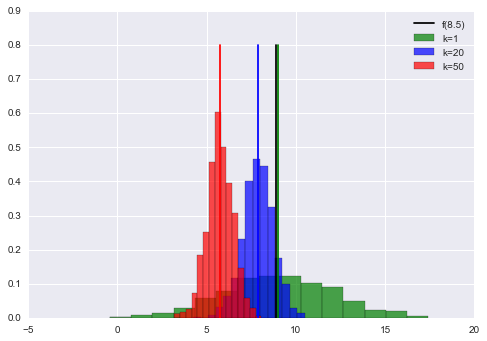

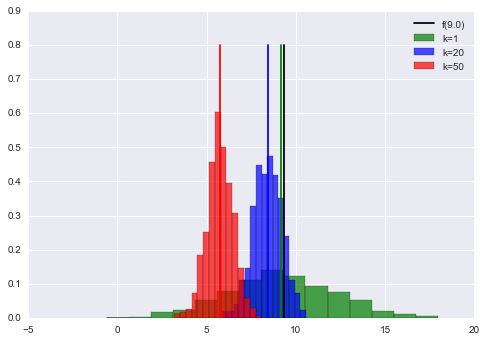

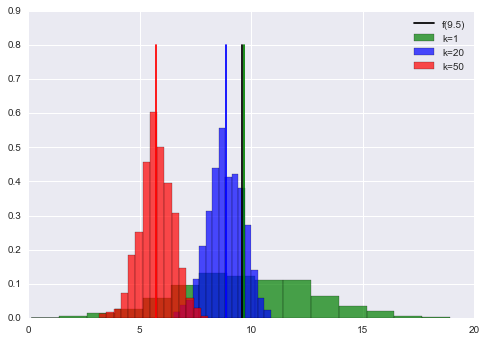

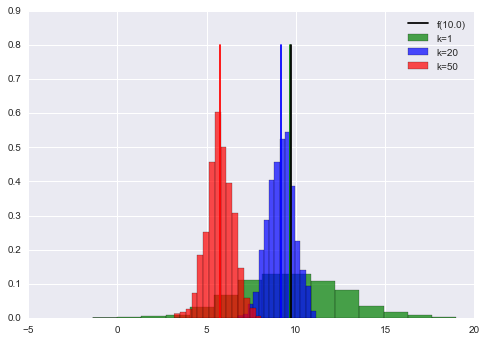

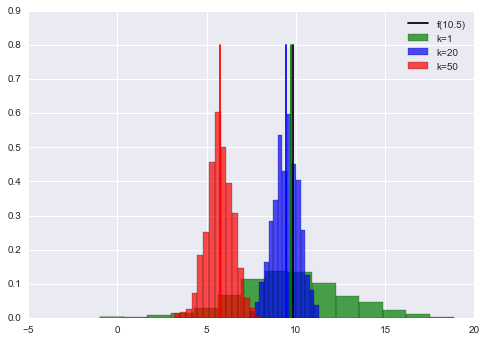

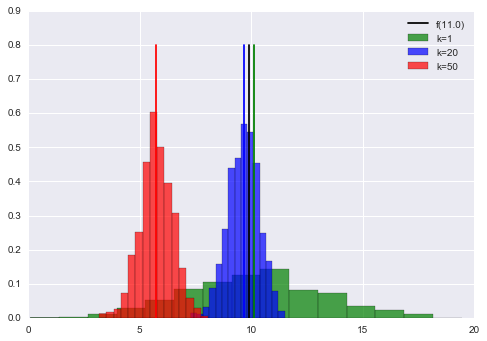

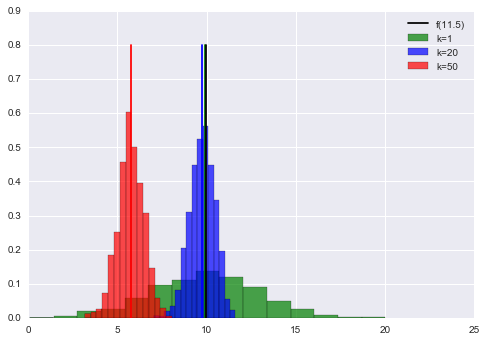

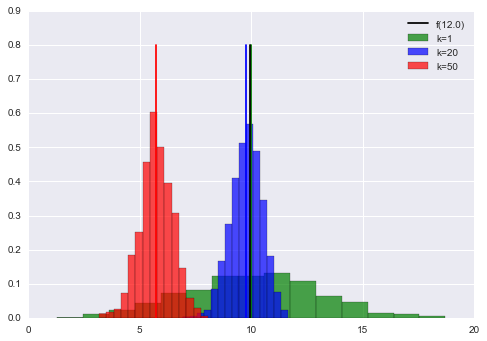

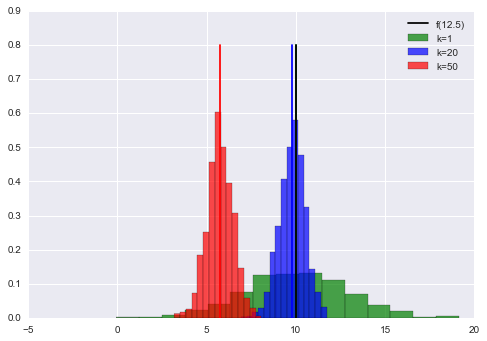

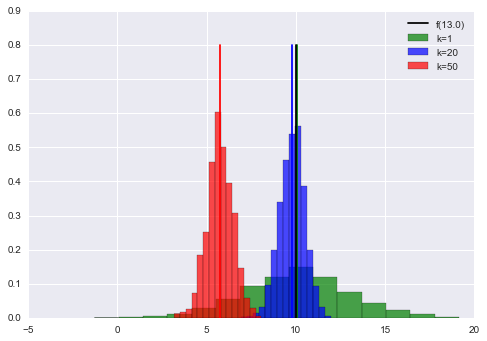

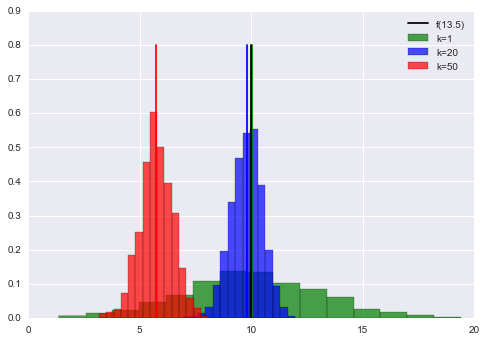

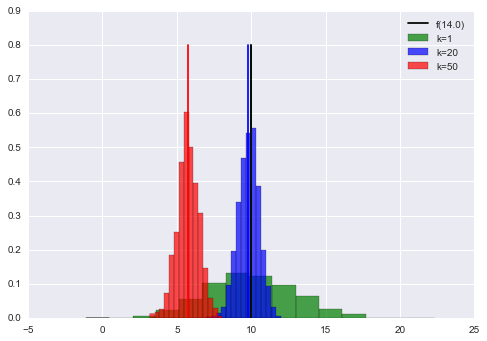

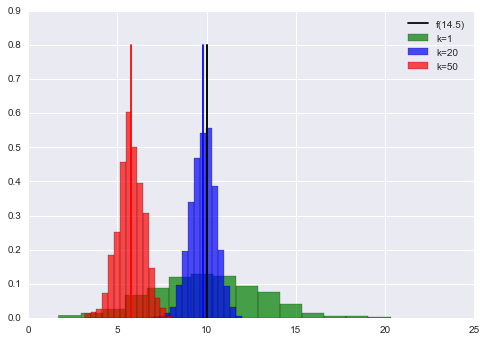

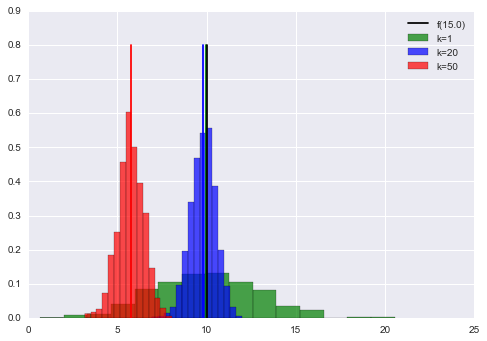

In [30]:
for ix_test_x in range(len(test_X)): # Iterate over all the test points
    test_x_val = test_X[ix_test_x] # Get the actual value of the test point
    # Plot the histogram of predictions at the current test point for the
    # k-nn model with 1 neighbor, and a vertical line at the average estimate 
    # of this model
    plt.hist(pred_dict[1][:,ix_test_x],color='green',bins=15,alpha=0.7,label='k=1',normed=True)
    plt.plot((np.mean(pred_dict[1][:,ix_test_x]),np.mean(pred_dict[1][:,ix_test_x])),(0,0.8),'-',color='green')
    
    # Do the same for the k-nn model with 20 neighbors
    plt.hist(pred_dict[20][:,ix_test_x],color='blue',bins=15,alpha=0.7,label='k=20',normed=True)
    plt.plot((np.mean(pred_dict[20][:,ix_test_x]),np.mean(pred_dict[20][:,ix_test_x])),(0,0.8),'-',color='blue')
    
    # Do the same for the k-nn model with 50 neighbors
    plt.hist(pred_dict[50][:,ix_test_x],color='red',bins=15,alpha=0.7,label='k=50',normed=True)
    plt.plot((np.mean(pred_dict[50][:,ix_test_x]),np.mean(pred_dict[50][:,ix_test_x])),(0,0.8),'-',color='red')
    
    # Draw a vertical line at the value of the true function f at the current test point
    plt.plot((true_fun(test_x_val),true_fun(test_x_val)),(0,0.8),'-',color='black',label='f(%s)'%test_x_val)
    plt.legend(loc='upper right')
    plt.show()

In the above plots, the horizontal distance between the black vertical line and one of the other vertical lines is the *bias* of the k-nn model represented by the red/green/blue vertical line.  The spread of the red/green/blue distribution represents the *variance* of the corresponding k-nn model.

Notice the following:
* The green vertical line is closest to the black vertical line in for every test point. This reflects the fact that the k-nn model with k=1 is the most flexible model, and therefore likely the least biased.  Alternatively, the red vertical line is always furthest away from the black vertical line, indicating the that highly inflexible k-nn model with 50 neighbors is the most biased.

* The green histogram always has the biggest spread, indicating that it has higher variance than the other two histograms. This reflects the fact that since the k-nn model with 1 neighbor is the most flexible, it's predictions at any test point always have the biggest variance.  On the other hand, the red histogram is always the narrowest (hard to tell at timee), reflecting the fact that the very inflexible k-nn model with 50 neighbors has the lowest variance in its predictions.

* These observations might suggest that using the k-nn model with 1 neighbor is best because it has the lowest bias.  However, in reality you often don't get to re-sample over and over in order to get an average prediction.  In fact, you typically only have one sample that you can use to make a prediction, and the high variance of the k-nn model with 1 neighbor means it's very likely that the *particular* training set you have will give a prediction that is very in accurate.  In other words, would you rather draw once from a very wide distribution that is, on average, on target, or from a narrower distribution that is, on average, slightly biased?

* In summary, the bias-variance tradeoff is reflected in this analysis because the k-nn model with 1 neighbor is clearly the least biased, though it has the highest variance, while the k-nn model with 50 neighbors is the most biased but has the least variance.  We would therefore need to select the value of $k$ that best manages this tradeoff.